# Gene Expression Analysis

# Environment

In [4]:
# Loading the Packages
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

### functions for cell-typing


In [5]:
import scanpy as sc
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import pickle

# Preprocessing
def adata_filter(adata, min_genes, min_counts, max_counts, min_cells):
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_cells(adata, max_counts=max_counts)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    return adata


def QC_plot(adata, hue, min_counts='nan', max_counts='nan', min_genes='nan', min_cells='nan'):
    g = sns.JointGrid(
        data=adata.obs,
        x="total_counts",
        y="n_genes_by_counts",
        height=5,
        ratio=2,
        hue=hue,
    )
    
    g.plot_joint(sns.scatterplot, s=40, alpha=0.3)
    g.plot_marginals(sns.kdeplot)
    g.set_axis_labels("total_counts", "n_genes_by_counts", fontsize=16)
    g.fig.set_figwidth(6)
    g.fig.set_figheight(6)
    g.fig.suptitle("QC_by_{}, cell_num={}, gene_num={}\n\
                   min_counts={}, max_counts={}, min_genes={}, min_cells={}\
                   \n\n\n\n\n".format(hue,len(adata),len(adata.var.index),min_counts, max_counts, min_genes, min_cells))
    plt.show()


def general_preprocess(adata, min_genes=2, min_counts=5, max_counts=200, min_cells=3, auto_filter=False, hue='dataset', alpha=0.5):
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

    fig = plt.figure(figsize=(12, 4))  # You can adjust the overall figure size here
    gs = gridspec.GridSpec(1, 3)
    # Plot top 20 most expressed genes
    ax1 = fig.add_subplot(gs[0, 0])
    sc.pl.highest_expr_genes(adata, n_top=10, ax=ax1, show=False)
    # distribution of cell counts
    ax2 = fig.add_subplot(gs[0, 1:3])
    counts = adata.obs.total_counts
    sns.histplot(counts, stat='count', ax=ax2,
                bins=int(np.percentile(counts, 90)), edgecolor='white', linewidth=0.5, alpha=1, 
                kde=True, line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'), kde_kws={'bw_adjust': 1},
                )
    y = ax2.get_lines()[0].get_ydata()
    maxima = [float(_/len(y)*(max(counts)-min(counts))+min(counts)) for _ in argrelextrema(-np.array(y), np.less)[0]]
    print(f'maxima: {maxima}')
    plt.tight_layout()
    plt.show()
    plt.close(fig=fig)
    
    
    # plot origin and filtered in a combined figure
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(3, 6)
    categories = adata.obs[hue].unique()

    ax_1_scatter = fig.add_subplot(gs[1:3, 0:2])
    sns.scatterplot(x=adata.obs.total_counts, y=adata.obs.n_genes_by_counts,
                    hue=adata.obs[hue], ax=ax_1_scatter, alpha=alpha)
    
    ax_1_count = fig.add_subplot(gs[0:1, 0:2])
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(subset.obs.total_counts, ax=ax_1_count)
    ax_1_count.xaxis.set_visible(False)
    ax_1_count.yaxis.set_visible(False)
    ax_1_count.grid(False)

    ax_1_gene = fig.add_subplot(gs[1:3, 2:3])
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(y=subset.obs.n_genes_by_counts, ax=ax_1_gene)
    ax_1_gene.xaxis.set_visible(False)
    ax_1_gene.yaxis.set_visible(False)
    ax_1_gene.grid(False)

    ax_1_count.set_title("QC_by_{}, cell_num={}, gene_num={}\n\
                         min_counts={}, max_counts={}, \n\
                         min_genes={}, min_cells={}\
                         ".format(hue, len(adata), len(adata.var.index), 'nan', 'nan', 'nan', 'nan'))

    origin_cell_num = len(adata)
    min_counts = int(maxima[0]) if auto_filter else min_counts
    max_counts = int(np.percentile(counts, 99.9)) if auto_filter else max_counts


    adata = adata_filter(adata, min_genes, min_counts, max_counts, min_cells)
    filtered_cell_num = len(adata)

    ax_2_scatter = fig.add_subplot(gs[1:3, 3:5])
    sns.scatterplot(x=adata.obs.total_counts, y=adata.obs.n_genes_by_counts,
                    hue=adata.obs[hue], ax=ax_2_scatter, alpha=alpha)
    
    ax_2_count = fig.add_subplot(gs[0:1, 3:5])
    categories = adata.obs[hue].unique()
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(subset.obs.total_counts, ax=ax_2_count)
    ax_2_count.xaxis.set_visible(False)
    ax_2_count.yaxis.set_visible(False)
    ax_2_count.grid(False)

    ax_2_gene = fig.add_subplot(gs[1:3, 5:6])
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(y=subset.obs.n_genes_by_counts, ax=ax_2_gene)
    ax_2_gene.xaxis.set_visible(False)
    ax_2_gene.yaxis.set_visible(False)
    ax_2_gene.grid(False)

    ax_2_count.set_title("QC_by_{}, cell_num={}, gene_num={}\n\
                         min_counts={}, max_counts={}, \n\
                         min_genes={}, min_cells={}\
                         ".format(hue, len(adata), len(adata.var.index), min_counts, max_counts, min_genes, min_cells))
    
    plt.tight_layout()
    
    plt.show()
    plt.close(fig=fig)

    # plot origin

    # QC_plot(adata, hue='dataset')

    # # plot filtered
    # min_counts = int(maxima[0]) if auto_filter else min_counts
    # max_counts = int(np.percentile(counts, 99.9)) if auto_filter else max_counts
    # adata = adata_filter(adata, min_genes, min_counts, max_counts, min_cells)
    # filtered_cell_num = len(adata)
    # QC_plot(adata, hue='dataset', min_genes=min_genes, min_counts=min_counts, max_counts=max_counts, min_cells=min_cells)
    return adata, origin_cell_num, filtered_cell_num


# g = sns.JointGrid(
#     data=adata.obs,
#     x="total_counts",
#     y="n_genes_by_counts",
#     height=5,
#     ratio=2,
#     hue=hue,
# )

# g.plot_joint(sns.scatterplot, s=40, alpha=0.3)
# g.plot_marginals(sns.kdeplot)
# g.set_axis_labels("total_counts", "n_genes_by_counts", fontsize=16)
# g.fig.set_figwidth(6)
# g.fig.set_figheight(6)
# g.fig.suptitle("QC_by_{}, cell_num={}, gene_num={}\n\
#                 min_counts={}, max_counts={}, min_genes={}, min_cells={}\
#                 \n\n\n\n\n".format(hue,len(adata),len(adata.var.index),min_counts, max_counts, min_genes, min_cells))
# plt.show()


def preprocess_of_UMAP(adata):
    # Normalization scaling
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    # Scale data to unit variance and zero mean
    sc.pp.regress_out(adata, ["total_counts"])
    sc.pp.scale(adata)
    return adata


def save_pos_on_UMAP(adata, out_dir):
    try:
        adata_coor = pd.DataFrame(
            adata.obsm["X_umap"], columns=["Coor_X", "Coor_Y"], index=adata.obs.index
        )
        df = pd.concat(
            [
                adata_coor["Coor_X"],
                adata_coor["Coor_Y"],
                pd.DataFrame(adata.obs.index),
                adata.obs.leiden,
            ],
            axis=1,
        )
        df.to_csv(out_dir)
    except KeyError:
        print('X_umap not found, please perform umap first.')


def save_cell_cluster(
    adata,
    out_path,
    st_point,
    cell_num,
    name="leiden",
):
    raw_clu = dict(adata.obs[name])
    cluster = dict()
    for cell_num in raw_clu.keys():
        cluster[cell_num] = -1

    for cell in raw_clu.keys():
        cluster[int(cell) - st_point] = int(raw_clu[cell])

    with open(out_path, "wb") as handle:
        pickle.dump(cluster, handle)


def UMAP_genes_plot(adata, FOI='', size=0.1, save=False, out_path='./', datatype='direct', dataset=[], vmax=None):
    n_pcs = len(adata.uns['pca']['variance'])
    n_neighbors = adata.uns['neighbors']['params']['n_neighbors']
    # Plot Gene distribution
    ncols = int(-(-len(adata.var_names)**(1/2)//1))
    nrows = -(-len(adata.var_names)//ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    for pos, gene_name in enumerate(list(adata.var_names)):
        sc.pl.umap(
            adata[adata.obs.dataset.isin(dataset)],
            size=size,
            color=gene_name,
            legend_fontweight=100,
            legend_fontsize=20,
            ax=ax[pos // ncols][pos % ncols],
            show=False,
            vmax=vmax,
            vmin=0,
        )
        ax[pos // ncols][pos % ncols].set_xticklabels("")
        ax[pos // ncols][pos % ncols].set_yticklabels("")

    fig.suptitle(
        "{}\nexp:{}\nUMAP:{}\n".format(
        f"{FOI}_{datatype}_{dataset}_UMAP",
        f"cell_num={len(adata)}",
        f"n_neighbors={n_neighbors}, n_pcs={n_pcs}"),
        fontsize=20,
    )
    plt.tight_layout()

    if save:
        plt.savefig(f"{out_path}/{FOI}_{datatype}_UMAP_genes.png")
        plt.close()
    else:
        plt.show()


def UMAP_leiden_plot(adata, FOI='', color='leiden', save=False, out_path='./',dpi=300, datatype='direct', DOI=['PRISM3D'], legend_loc='on data', palette=False, size=1):
    n_pcs = len(adata.uns['pca']['variance'])
    n_neighbors = adata.uns['neighbors']['params']['n_neighbors']
    resolution = adata.uns['leiden']['params']['resolution']
    # Plot Cluster
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    
    if palette:
        sc.pl.umap(
            adata[adata.obs.dataset.isin(DOI)],
            size=size, color=color, palette=palette, 
            legend_loc=legend_loc, legend_fontsize=7,
            ax=ax[0], show=False,
        )

        sc.pl.umap(
            adata,
            size=size, color="dataset",
            legend_fontweight=100, legend_fontsize=20,
            ax=ax[1], show=False,
        )
    else:
        sc.pl.umap(
            adata[adata.obs.dataset.isin(DOI)],
            size=size, color=color,
            legend_loc=legend_loc, legend_fontsize=7,
            ax=ax[0], show=False,
        )

        sc.pl.umap(
            adata,
            size=size, color="dataset",
            legend_fontweight=100, legend_fontsize=20,
            ax=ax[1], show=False,
        )
    fig.suptitle(
        "{}\nexp:{}\nUMAP:{}\n".format(
        f"{FOI}_{datatype}_cluster",
        f"cell_num={len(adata)}",
        f"n_neighbors={n_neighbors}, n_pcs={n_pcs}, resolution={resolution}"),
        fontsize=20,
    )
    plt.tight_layout()
    if save:
        if out_path.endswith('.png'):    
            plt.savefig(f"{out_path}", bbox_inches = 'tight', dpi=dpi)
        else:
            plt.savefig(f"{out_path}", bbox_inches = 'tight')
        plt.close()
    else:
        plt.show()


def leiden_QC_plot(adata, color='leiden'):
    # cluster QC
    g = sns.JointGrid(
        data=adata.obs,
        x="total_counts",
        y="n_genes_by_counts",
        height=5,
        ratio=2,
        hue=color,
    )
    g.plot_joint(sns.scatterplot, s=40, alpha=0.3)
    g.plot_marginals(sns.kdeplot)
    g.set_axis_labels("total_counts", "n_genes_by_counts", fontsize=8)
    g.fig.set_figwidth(3)
    g.fig.set_figheight(3)
    plt.show()

### functions for projection

In [6]:
# cell show
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt


plt.style.use("default")  # alternative: 'dark_background'


def create_hull(adata, clus_obs="leiden", cont_thre=15, rna_pos=[]):
    factor_data = {
        "Cell_Index": [str(_) for _ in adata.obs.index],
        "Cluster": [int(_) for _ in adata.obs[clus_obs]],
    }
    factor = pd.DataFrame(factor_data).set_index("Cell_Index")
    cluster_num = np.unique(factor["Cluster"])

    type_indices = {}
    for cell_type in cluster_num:
        type_indices[cell_type] = list(factor[factor["Cluster"] == cell_type].index)

    hulls = {}
    df_group = rna_pos.groupby("Cell Index")

    for group in tqdm(df_group, desc="hull"):
        coordinates = group[1][["Y", "X"]].values
        if len(coordinates) < cont_thre:
            continue
        try:
            hull = ConvexHull(coordinates)
        except:
            continue
        coordinate_path = np.vstack(
            (coordinates[hull.vertices, 0], coordinates[hull.vertices, 1])
        ).T
        hulls[group[0]] = coordinate_path
    return hulls, type_indices


def show_cluster(hulls, type_indices, cluster_list, cluster_colormap=["red"] * 200, ax='', linewidth=0.1, name='projection', show=True, save=False, outpath=''):
    cell = 0
    for ind in cluster_list:
        for idx in tqdm(type_indices[ind], desc=f'cell for cluster{ind}'):
            idx = int(idx)
            try:
                ax.fill(
                    hulls[idx][:, 1],
                    hulls[idx][:, 0],
                    color=cluster_colormap[ind],
                    linewidth=linewidth,
                    alpha=1,
                )
                cell += 1
            except KeyError:
                pass
    ax.set_xlim([0, 45000])
    ax.set_ylim([0, 40000])
    ax.set_title(f"{name}, cell_num={cell}")
    print(f'{cell} cells have been ploted.')
    
    if save:
        plt.savefig(outpath)
    elif show:
        plt.show()
    else:
        pass    

In [7]:
# plot example
# combine_adata_st = combine_adata[combine_adata.obs.dataset == 'st']
# combine_adata_st.obs.index = [_.replace('-st','') for _ in combine_adata_st.obs.index]
# hulls, type_indices = create_hull(combine_adata_st, clus_obs="leiden", cont_thre=15)
# show_cluster(hulls, type_indices, cluster_list, cluster_colormap=["red"] * 200)

### functions to threshold in cluster

In [8]:
def threshold_in_cluster(adata, marker_gene=[], thre_gene=['AFP','GPC3','ACTA2','PECAM1'], type_name=[], cluster_dict={}):
# for cluster_gene in cluster_to_filter:
    thre_min = [True] * len(marker_gene) + [False] * len(thre_gene)
    gene_list = marker_gene + thre_gene
    minima_dict = {}
    for _ in gene_list:
        minima_dict[_] = ''

    cluster_list_temp=[]
    for _ in cluster_dict.keys():
        for name in type_name:
            if name in _:
                cluster_list_temp += [str(_) for _ in cluster_dict[_]]

    cluster = adata[adata.obs.leiden.isin(cluster_list_temp)]

    fig, ax = plt.subplots(nrows=1,ncols=len(thre_min),figsize=(24, 4))
    for i, gene in enumerate(gene_list):
        a = [float(_) for _ in cluster[:, gene].X]
        sns.histplot(a, bins=20, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    log=True, 
                    ax=ax[i],
                    line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'))
        ax[i].get_lines()[0].set_color('red') # edit line color due to bug in sns v 0.11.0
        ax[i].set_xlabel(gene)

        y = ax[i].get_lines()[0].get_ydata()
        minima_dict[gene] = [float(_/len(y)*(max(a)-min(a))+min(a)) for _ in argrelextrema(np.array(y), np.less)[0]]
        # print(f'{gene}_minima: {minima_dict[gene]}')
        fig.subplots_adjust(hspace=0.4)
        fig.subplots_adjust(wspace=0.4)
        fig.suptitle(f'distribution of cluster, marker gene={marker_gene}')
    plt.show()

    cluster.obs['tmp_leiden'] = ['-1']*len(cluster)
    for _, gene in enumerate(gene_list):
        minima = minima_dict[gene]
        while True:
            if len(minima) == 0:
                minima = [0]
                break
            if minima[0] > 1 and gene != 'CPA3':
                minima[0] = 0
                break
            if minima[0] < -1 and gene != 'CPA3':
                minima.pop(0)
                continue
            break
        
        print(f'{gene}_thre: {minima[0]}')

        if thre_min[_]:
            tmp = cluster[cluster[:, gene].X > minima[0]]
            cluster.obs['tmp_leiden'][tmp.obs.index] = ['1']*len(tmp)
        else:
            tmp = cluster[cluster[:, gene].X > minima[0]]
            cluster.obs['tmp_leiden'][tmp.obs.index] = ['-1']*len(tmp)
    
    tmp = cluster[cluster.obs['tmp_leiden']=='-1']
    adata.obs['tmp_leiden'][tmp.obs.index] = ['-2']*len(tmp)

    cell_to_plot = len(cluster[cluster.obs['tmp_leiden']=='1'])
    print(f'marker_gene={marker_gene}, {cell_to_plot} cells of {len(cluster)} cells left\n')
    return adata


def collect_liver(combine_adata_st, tissue_obs='tissue', in_out_leiden='tmp_leiden'):
    other_cluster = combine_adata_st[combine_adata_st.obs[in_out_leiden]=='-2']
    liver = other_cluster[other_cluster.obs[tissue_obs] == "liver"]
    combine_adata_st.obs[in_out_leiden] = list(combine_adata_st.obs[in_out_leiden])
    combine_adata_st.obs[in_out_leiden][liver.obs.index] = ["-1"] * len(liver)
    return combine_adata_st

### functions for ROI

In [9]:
from skimage import io, transform, morphology
def ROI_mask_load(input_path, out_path, save=False, blur=True):
    ROI_mask = {}
    for mask_file in os.listdir(input_path):
        image = io.imread(os.path.join(input_path, mask_file))
        if blur:
            image = transform.rotate(image, angle=90, resize=True)
            image = morphology.binary_dilation(image, footprint=morphology.disk(5))
        ROI_mask[mask_file.replace('.tif','').replace('Mask', 'ROI')] = image
        
    ncols = int(-(-len(ROI_mask)**(1/2)//1))
    nrows = -(-len(ROI_mask)//ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    for pos, mask_name in enumerate(list(ROI_mask.keys())):
        try:
            ax[pos // ncols][pos % ncols].imshow(ROI_mask[mask_name])
        except:
            ax[pos // ncols][pos % ncols].imshow(ROI_mask[mask_name][0,:,:])
        ax[pos // ncols][pos % ncols].set_title(mask_name)
        ax[pos // ncols][pos % ncols].set_xlabel("")
        ax[pos // ncols][pos % ncols].set_ylabel("")
    fig.suptitle('Mask_of_ROIs', fontsize=20)
    plt.tight_layout()

    if save:
        plt.savefig('{}/{}.png'.format(out_path, 'mask_of_ROIs'))
    else:
        plt.show()

    return ROI_mask

### funtions for heatmap matrix

In [10]:
def matrix_for_heatmap(adata_1, adata_2, adata_ori, obs_1="leiden_type", obs_2="leiden", cluster_of_intere=list, sc_cluster_of_intere=list, save=False, whole=False):
    
    raw_cluster_num = len(cluster_of_intere)
    sc_cluster_num = len(sc_cluster_of_intere)
    raw_data_matrix = np.array([])
    raw_data_whole_matrix = np.array([])
    sc_data_matrix = np.array([])

    for cluster_num in cluster_of_intere:
        if whole:
            raw_add_whole = np.array(
                [
                    np.mean(
                        adata_ori[adata_1[adata_1.obs[obs_1] == str(cluster_num)].obs.index].X,
                        axis=0,
                    )
                ]
            )
            if raw_data_whole_matrix.size == 0:
                raw_data_whole_matrix = raw_add_whole
            else:
                raw_data_whole_matrix = np.concatenate((raw_data_whole_matrix, raw_add_whole), axis=0)

        raw_add = np.array([np.mean(adata_1.X[adata_1.obs[obs_1] == str(cluster_num)], axis=0)])
        if raw_data_matrix.size == 0:
            raw_data_matrix = raw_add
        else:
            raw_data_matrix = np.concatenate((raw_data_matrix, raw_add), axis=0)


    for cluster_num in sc_cluster_of_intere:
        sc_add = np.array([np.mean(adata_2.X[adata_2.obs[obs_2] == str(cluster_num)], axis=0)])
        if sc_data_matrix.size == 0:
            sc_data_matrix = sc_add
        else:
            sc_data_matrix = np.concatenate((sc_data_matrix, sc_add), axis=0)

    matrix = np.concatenate((raw_data_matrix, sc_data_matrix), axis=0)
    corr_matrix = np.corrcoef(matrix)
    if whole:
        return raw_data_whole_matrix, sc_data_matrix, corr_matrix[0 : raw_cluster_num, raw_cluster_num : raw_cluster_num + sc_cluster_num]
    else:
        return raw_data_matrix, sc_data_matrix, corr_matrix[0 : raw_cluster_num, raw_cluster_num : raw_cluster_num + sc_cluster_num]

## workdir

In [11]:
BASE_DIR = Path('E:\TMC\PRISM_Code\dataset\processed')
RUN_ID = '20230704_PRISM3D_mousebrain_CTX_rm_doublet'
src_dir = BASE_DIR / f'{RUN_ID}'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
celltyping_dir = src_dir / 'analysis_celltyping'

# exp data load and preprocess

In [12]:
# load expression matrix
raw_adata = pd.read_csv(seg_dir / "expression_matrix.csv", index_col=0)
adata = sc.AnnData(raw_adata)
adata.var.index = adata.var.index.str.upper()
adata.obs['dataset'] = ["PRISM3D"] * len(adata)
adata.obs['tissue'] = ['mousebrain_CTX'] * len(adata)
adata.obs.index = [int(_) for _ in adata.obs.index]
adata.raw = adata

In [13]:
# load spatial information
centroid = pd.read_csv(seg_dir / 'dapi_predict.csv', index_col=0)
centroid_sub = centroid.loc[adata.obs.index]
adata.obsm['spatial'] = np.array([centroid_sub['y_in_pix'], centroid_sub['x_in_pix']]).T
adata.obsm['spatial3d'] = np.array([centroid_sub['x_in_pix'], 
                                    centroid_sub['y_in_pix'], 
                                    centroid_sub['z_in_pix']*3.36]).T

## Preprocess

maxima: [7.45]


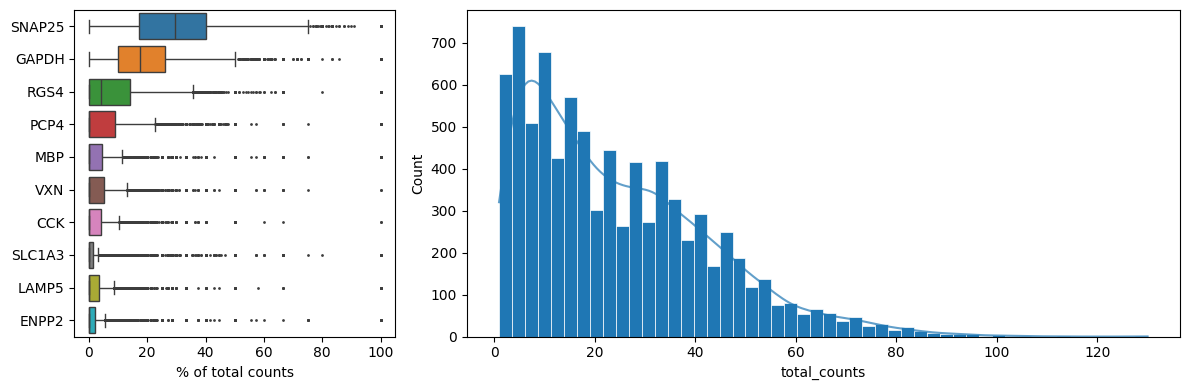

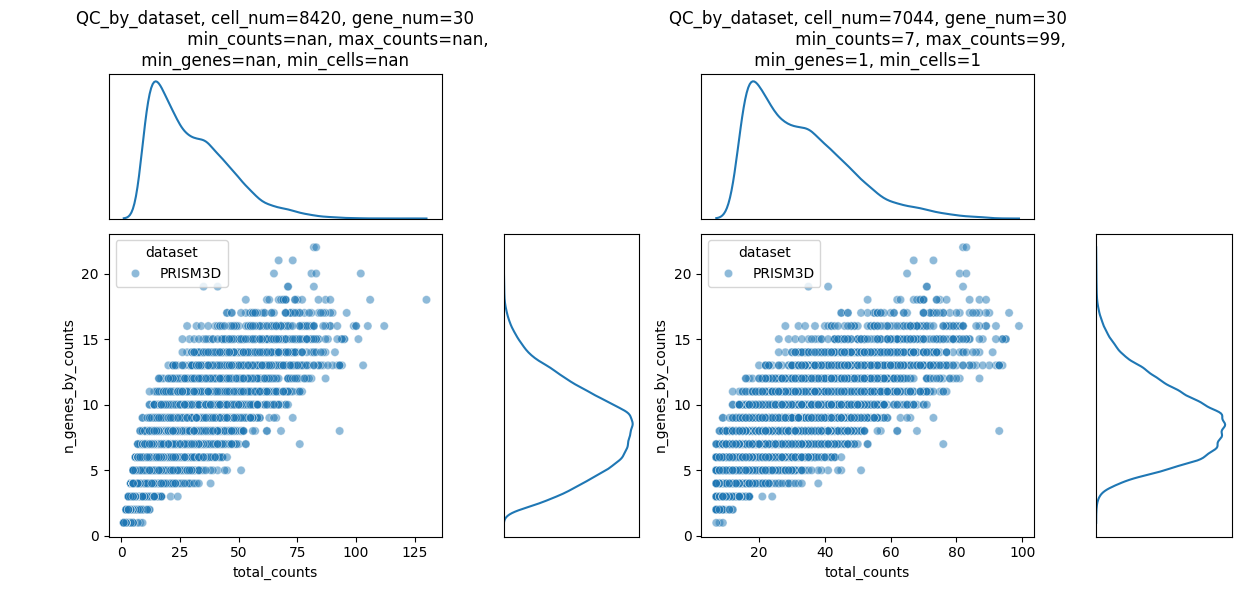

In [14]:
# process of gene name
adata, origin_cell_num, filtered_cell_num = general_preprocess(adata, min_genes=1, min_counts=5, max_counts=150, min_cells=1, auto_filter=True)

# copy the meta data of adata
adata_meta = adata.copy()

# direct leiden


## process

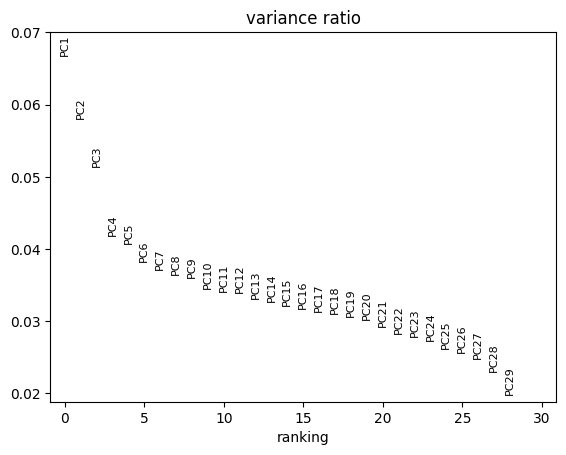

In [15]:
adata = adata_meta.copy()
# preprocess of UMAP
adata = preprocess_of_UMAP(adata)

# compute pca
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=False)

In [16]:
# select the num of pc
n_pcs=20
sc.tl.pca(adata, n_comps=n_pcs)                                                                               

In [17]:
# Run UMAP
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=n_pcs)
sc.tl.umap(adata)

: 

In [ ]:
# Run Leiden cluster
sc.tl.leiden(adata, resolution=1)

## overview

### cell num of each leiden cluster

In [ ]:
a = [len(adata[adata.obs.leiden == _]) for _ in adata.obs.leiden.unique()]
fig, ax = plt.subplots(figsize=(7,3))
sns.histplot(a, bins=30, stat='count', alpha=1, kde=True,
            edgecolor='white', linewidth=0.5,
            # log=True, 
            ax=ax,
            line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
            # binrange=[0,100]
            )
plt.show()

adata_thre = adata[adata.obs.leiden.isin([_ for _ in adata.obs.leiden.unique() if len(adata[adata.obs.leiden == _]) > 100])]

### boxplot

In [ ]:
unknown_cluster = [str(_) for _ in sorted([int(_) for _ in adata.obs.leiden.unique()])]
fig, ax = plt.subplots(ncols=1, nrows=len(unknown_cluster),figsize =(25, 100))
for _, cluster_num  in enumerate(unknown_cluster):
    data = adata[adata.obs['leiden'] == cluster_num].X
    ax[_].boxplot(data, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
    ax[_].set_xticklabels(list(adata.var_names))
    ax[_].set_title(f'cluster{cluster_num}')
plt.show()

### umap by gene

In [ ]:
UMAP_genes_plot(adata, FOI=os.path.split(workdir)[-1], save=False, datatype='direct', dataset=["PRISM3D"], size=10)

### umap by leiden

In [ ]:
UMAP_leiden_plot(adata, FOI=os.path.split(workdir)[-1], color='leiden', save=False, out_path=os.path.join(workdir, 'cell_typing'), datatype='direct', size=20)
QC_plot(adata, hue='leiden')

## annotate interested clusters

### spatial preview

In [ ]:
adata.obs.index = [int(_) for _ in adata.obs.index]

In [ ]:
# load spatial information
centroid = pd.read_csv(os.path.join(workdir, 'dapi_predict.csv'), index_col=0)
centroid_sub = centroid.loc[adata.obs.index]
adata.obsm['spatial'] = np.array([centroid_sub['y_in_pix'], centroid_sub['x_in_pix']]).T
adata.obsm['spatial3d'] = np.array([centroid_sub['x_in_pix'], 
                                    centroid_sub['y_in_pix'], 
                                    centroid_sub['z_in_pix']*3.36]).T

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec


group = [5, 9]
group = [str(_) for _ in group]
tmp = adata[adata.obs.leiden.isin(group)]


fig = plt.figure(figsize=(20, 11))
gs = gridspec.GridSpec(10, 10)

ax_box = fig.add_subplot(gs[:2, :])
data = adata[adata.obs['leiden'].isin(group)].X
ax_box.boxplot(data, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
ax_box.set_xticklabels(list(adata.var_names))
ax_box.set_title(f'cluster{group}')

ax_2d = fig.add_subplot(gs[2:, :6])
ax_2d.invert_yaxis()
sc.pl.embedding(
    tmp, basis="spatial", color="leiden", palette=['red', 'blue'], #palette=['brown'] * len(group),
    size=50, alpha=1, ax=ax_2d, show=False)

ax_3d = fig.add_subplot(gs[2:, 6:], projection='3d', )
sc.pl.embedding(
    tmp, basis="spatial3d", projection="3d", color="leiden", palette=['red', 'blue'], #palette=['brown'] * len(group),
    size=5, alpha=0.5, ax=ax_3d, show=False)
elev, azim = 90, 0
ax_3d.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()

### relabel mapping

In [ ]:
cluster_dict = {
    "Ex-2or3":[7, 12],
    "Ex-4":[5, 9],
    "Ex-5":[],
    "Ex-6a":[0, 17],
    "Ex-6b":[13],

    "In-Sst":[14],
    "In-Pvalb":[4],
    "In-Vip":[10],
    "In-Lamp5":[],

    "Glial-Astrocyte":[8, 16],
    "Glial-Microglia":[2],
    "Glial-Oligodendrocyte":[11],
}

cluster_rough_dict = {
    "Ex":[],
    "In":[],
    "Glial":[],    
}
for rough_type in cluster_rough_dict.keys():
    for fine_type in cluster_dict.keys():
        if rough_type in fine_type:
            cluster_rough_dict[rough_type] += cluster_dict[fine_type]

In [ ]:
subtype_colormap = {
    "Ex-2or3":(0,0,1), "Ex-4":(0,1,0), "Ex-5":(1,1,0), "Ex-6a":(1,0,1), "Ex-6b":(1,0,0),
    "In-Lamp5":(1,0.5,0), "In-Sst":(1,0.8,0), "In-Pvalb":(0.5,0.5,0.5), "In-Vip":(1,0.35,0), 
    "Glial-Astrocyte":(1,0.72,0.75), "Glial-Microglia":(0,1,1), "Glial-Oligodendrocyte":(0.33,0.33,1),
}

### relabel of num and cluster name

In [ ]:
def re_num_leiden(combine_adata_st, cluster_dict, in_leiden='tmp_leiden', out_leiden='new_leiden', out_type='type'):
    combine_adata_st.obs[out_leiden] = ["-2"] * len(combine_adata_st)
    combine_adata_st.obs[out_type] = ["other"] * len(combine_adata_st)
    for cluster_num, cluster_name in enumerate(cluster_dict.keys()):
        for sub_cluster in cluster_dict[cluster_name]:
            temp = combine_adata_st[combine_adata_st.obs[in_leiden] == str(sub_cluster)]
            combine_adata_st.obs[out_leiden][temp.obs.index] = [str(cluster_num)] * len(temp)
            combine_adata_st.obs[out_type][temp.obs.index] = [str(cluster_name)] * len(temp)
    temp = combine_adata_st[combine_adata_st.obs[out_leiden] == '-2']
    combine_adata_st.obs[out_type][temp.obs.index] = ['other'] * len(temp)
    return combine_adata_st

In [ ]:
# rename leidens based on cluster_dict
adata = re_num_leiden(adata, cluster_dict, in_leiden='leiden', out_leiden='leiden_subtype', out_type='subtype')
adata = re_num_leiden(adata, cluster_rough_dict, in_leiden='leiden', out_leiden='leiden_type', out_type='type')
adata.obs = adata.obs.dropna(axis=1)

In [ ]:
counts = []
for cell_type in cluster_dict.keys():
    cell_num = adata[adata.obs.subtype == cell_type].obs.subtype.count()
    print(f'{cell_type}: {cell_num}')
    counts.append(cell_num)
print('total_exempt_other:',len(adata[adata.obs.subtype.isin(cluster_dict.keys())]))
print('total:',len(adata))

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=cluster_dict.keys(), autopct='%1.1f%%', startangle=140, colors=subtype_colormap.values())
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('{} Cell Type Distribution'.format(workdir.split('_')[-3]))
plt.tight_layout()
plt.savefig(os.path.join(workdir, 'cell_typing', 'annotated_subtype_cell_num.png'), bbox_inches='tight', dpi=300)

In [ ]:
# save the adata
adata.write_h5ad(os.path.join(workdir, 'cell_typing', 'direct', 'adata.h5ad'))

# Writing the list to a text file
with open(os.path.join(workdir, 'cell_typing', 'direct', 'annotated_subtype.txt'), 'w') as file:
    for item in cluster_dict.keys():
        file.write(f"{item}\n")

with open(os.path.join(workdir, 'cell_typing', 'direct', 'annotated_type.txt'), 'w') as file:
    for item in cluster_rough_dict.keys():
        file.write(f"{item}\n")

# cell num
with open(os.path.join(workdir, 'cell_typing', 'direct', 'annotated_subtype_cell_num.txt'), 'w') as file:
    for cell_type in cluster_dict.keys():
        cell_num = adata[adata.obs.subtype == cell_type].obs.subtype.count()
        file.write(f"{cell_type}: {cell_num}\n")
    file.write('total_exempt_other: {}\n'.format(len(adata[adata.obs.subtype.isin(cluster_dict.keys())])))
    file.write('total_num: {}\n'.format(len(adata)))

with open(os.path.join(workdir, 'cell_typing', 'direct', 'annotated_type_cell_num.txt'), 'w') as file:
    for cell_type in cluster_rough_dict.keys():
        cell_num = adata[adata.obs.type == cell_type].obs.type.count()
        file.write(f"{cell_type}: {cell_num}\n")
    file.write('total_exempt_other: {}\n'.format(len(adata[adata.obs.type.isin(cluster_rough_dict.keys())])))
    file.write('total_num: {}\n'.format(len(adata)))

## spatial projection

In [ ]:
adata = sc.read_h5ad(os.path.join(workdir, 'direct', 'adata.h5ad'))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

tmp = adata.copy()

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 10)
ax_2d = fig.add_subplot(gs[0, :5])
sc.pl.embedding(
    tmp, 
    basis="spatial", color="subtype", #palette=palette,
    size=50, alpha=1, ax=ax_2d, show=False)
ax_2d.set_xlim([-100, 6500])
ax_2d.set_ylim([-100, 2000])
ax_2d.invert_yaxis()

ax_3d = fig.add_subplot(gs[0, 5:], projection='3d', )
sc.pl.embedding(tmp,
                basis="spatial3d", projection="3d", color="subtype", #palette=palette,
                size=1, alpha=1, ax=ax_3d, show=False)
ax_3d.set_xlim([-200, 2200])
ax_3d.set_ylim([-200, 6500])
ax_3d.set_zlim([-100, 200])

# Set view angle
elev, azim = 90, 0
ax_3d.view_init(elev=elev, azim=azim)

plt.tight_layout()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'spatial_overview.png'), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

tmp = combine_adata_st[combine_adata_st.obs.subtype.isin(["Ex-2or3", 'Ex-4', 'Ex-5', 'Ex-6a', 'Ex-6b'])]

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 10)
ax_2d = fig.add_subplot(gs[0, :5])
sc.pl.embedding(
    tmp, 
    basis="spatial", color="subtype", #palette=palette,
    size=70, alpha=1, ax=ax_2d, show=False)
ax_2d.set_xlim([-100, 6500])
ax_2d.set_ylim([-100, 2000])
ax_2d.invert_yaxis()

ax_3d = fig.add_subplot(gs[0, 5:], projection='3d', )
sc.pl.embedding(tmp,
                basis="spatial3d", projection="3d", color="subtype", #palette=palette,
                size=1, alpha=1, ax=ax_3d, show=False)
ax_3d.set_xlim([-200, 2200])
ax_3d.set_ylim([-200, 6500])
ax_3d.set_zlim([-100, 200])

# Set view angle
elev, azim = 90, 0
ax_3d.view_init(elev=elev, azim=azim)

plt.tight_layout()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'spatial_overview.png'), bbox_inches='tight', dpi=300)
plt.show()

# harmony combine

## load sc data

In [ ]:
adata_sc1 = sc.read_h5ad(r'e:\TMC\cell_typing\dataset_sc_rnaseq\sc_data_mousebrain\cache\l1_cortex1.h5ad')
adata_sc2 = sc.read_h5ad(r'e:\TMC\cell_typing\dataset_sc_rnaseq\sc_data_mousebrain\cache\l1_cortex2.h5ad')
adata_sc3 = sc.read_h5ad(r'e:\TMC\cell_typing\dataset_sc_rnaseq\sc_data_mousebrain\cache\l1_cortex3.h5ad')
adata_sc1.var_names_make_unique()
adata_sc2.var_names_make_unique()
adata_sc3.var_names_make_unique()
adata_sc1.obs['dataset'] = ['mousebrain_CTX1'] * len(adata_sc1)
adata_sc2.obs['dataset'] = ['mousebrain_CTX2'] * len(adata_sc2)
adata_sc3.obs['dataset'] = ['mousebrain_CTX3'] * len(adata_sc3)

In [ ]:
adata_sc = adata_sc1.concatenate(adata_sc2, adata_sc3, batch_key="dataset", batch_categories=["mousebrain_CTX1", "mousebrain_CTX2", 'mousebrain_CTX3'])
# adata_sc = adata_sc2.copy()
adata_sc.var.index = adata_sc.var.index.str.upper()
index_series = pd.Series(adata_sc.var.index)
index_series = index_series.replace({'3110035E14RIK': 'VXN'})
adata_sc.var.index = pd.Index(index_series)
adata_sc.var_names_make_unique()

# process of gene name
adata_sc, origin_cell_num, filtered_cell_num = general_preprocess(adata_sc, min_genes=0, min_counts=500, max_counts=25000, min_cells=0, auto_filter=False)
adata_sc_meta = adata_sc.copy()

In [ ]:
list_of_variable_names = adata.var_names
adata_sc_subset = adata_sc[:, list_of_variable_names]
adata_sc_subset = preprocess_of_UMAP(adata_sc_subset)

## process

In [ ]:
adata_sc_subset1 = adata_sc_subset[adata_sc_subset.obs.dataset == "mousebrain_CTX1"]
adata_sc_subset2 = adata_sc_subset[adata_sc_subset.obs.dataset == "mousebrain_CTX2"]
adata_sc_subset3 = adata_sc_subset[adata_sc_subset.obs.dataset == "mousebrain_CTX3"]
combine_adata = adata.concatenate(adata_sc_subset1, adata_sc_subset2, adata_sc_subset3, batch_key="dataset", batch_categories=["PRISM3D", "mousebrain_CTX1", "mousebrain_CTX2", "mousebrain_CTX3"])

print("origin_gene_num:", len(adata.var.index))
print("combine_gene_num:", len(combine_adata.var.index))
print("Genes_not_matched:", ','.join(list(set(adata.var.index) - set(combine_adata.var.index))))

In [ ]:
sc.tl.pca(combine_adata, n_comps=29)
sc.pl.pca_variance_ratio(combine_adata, log=False)

h_pcs = 29
sc.tl.pca(combine_adata, n_comps=h_pcs)
sc_cell_num = len(combine_adata) - len(adata)
print(combine_adata)

In [ ]:
import scanpy.external as sce

sce.pp.harmony_integrate(
    combine_adata,
    "dataset",
    "X_pca",
    "X_pca_harmony",
    max_iter_harmony=30,
    # max_iter_kmeans=30,
)

In [ ]:
neighbor = 50
sc.pp.neighbors(combine_adata, n_neighbors=neighbor, use_rep="X_pca_harmony")
sc.tl.umap(combine_adata)

In [ ]:
leiden_resolution=1
sc.tl.leiden(combine_adata, resolution=leiden_resolution)

## overview

### cell num of each leiden cluster

In [ ]:
combine_adata_exp = combine_adata[combine_adata.obs.dataset == 'PRISM3D']
a = [len(combine_adata_exp[combine_adata_exp.obs.leiden == _]) for _ in combine_adata_exp.obs.leiden.unique()]
fig, ax = plt.subplots(figsize=(7,3))
sns.histplot(a, bins=30, stat='count', 
             alpha=1, edgecolor='white', linewidth=0.5, ax=ax,
             kde=True, line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
            )
plt.show()

combine_adata_exp_thre = combine_adata_exp[combine_adata_exp.obs.leiden.isin([_ for _ in combine_adata_exp.obs.leiden.unique() if len(combine_adata_exp[combine_adata_exp.obs.leiden == _]) > 50])]

### boxplot

In [ ]:
unknown_cluster = [str(_) for _ in sorted([int(_) for _ in combine_adata.obs.leiden.unique()])]
fig, ax = plt.subplots(ncols=1, nrows=len(unknown_cluster),figsize =(25, 100))
for _, cluster_num  in enumerate(unknown_cluster):
    data = combine_adata[combine_adata.obs['leiden'] == cluster_num].X
    ax[_].boxplot(data, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
    ax[_].set_xticklabels(list(combine_adata.var_names))
    ax[_].set_title(f'cluster{cluster_num}')
plt.savefig(os.path.join(workdir, 'cell_typing', 'boxplot_by_leiden.png'))
plt.close()

### umap by gene

In [ ]:
UMAP_genes_plot(combine_adata, FOI=os.path.split(workdir)[-1], save=False, datatype='harmony', dataset=['PRISM3D'], size=5)

### umap by leiden

In [ ]:
UMAP_leiden_plot(combine_adata, FOI=os.path.split(workdir)[-1], color='leiden', save=False, out_path=out_path, datatype='harmony', DOI=['PRISM3D'], size=10)

## annotate interested clusters

### spatial preview

In [ ]:
combine_adata_st = combine_adata[combine_adata.obs.dataset == 'PRISM3D']
combine_adata_st.obs.index = [int(_.split('-')[0]) for _ in combine_adata_st.obs.index]

In [ ]:
# load spatial information
centroid = pd.read_csv(os.path.join(workdir, 'dapi_predict.csv'), index_col=0)
centroid_sub = centroid.loc[combine_adata_st.obs.index]
combine_adata_st.obsm['spatial'] = np.array([centroid_sub['y_in_pix'], centroid_sub['x_in_pix']]).T
combine_adata_st.obsm['spatial3d'] = np.array([centroid_sub['x_in_pix'], 
                                    centroid_sub['y_in_pix'], 
                                    centroid_sub['z_in_pix']*3.36]).T

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

group = [
0,8
         ]
group = [str(_) for _ in group]

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 10)

ax_2d = fig.add_subplot(gs[0, :5])
sc.pl.embedding(
    # combine_adata_st,
    combine_adata_st[combine_adata_st.obs.leiden.isin(group)], 
    basis="spatial", color="leiden", #palette=['brown'],
    size=50, alpha=1, ax=ax_2d, show=False)
ax_2d.set_xlim([-100, 6500])
ax_2d.set_ylim([-100, 2000])
ax_2d.invert_yaxis()

ax_3d = fig.add_subplot(gs[0, 5:], projection='3d', )
sc.pl.embedding(
    # combine_adata_st,
    combine_adata_st[combine_adata_st.obs.leiden.isin(group)], 
    basis="spatial3d", projection="3d", color="leiden", #palette=['brown'],
    size=1, alpha=1, ax=ax_3d, show=False)
ax_3d.set_xlim([-200, 2200])
ax_3d.set_ylim([-200, 6500])
ax_3d.set_zlim([-100, 200])

# Set view angle
elev, azim = 90, 0
ax_3d.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()

In [ ]:
combine_adata_st[combine_adata_st.obs.leiden=='2']

### relabel mapping

In [ ]:
cluster_dict = {
    "Ex-2or3":[1],
    "Ex-4":[3],
    "Ex-5":[5],
    "Ex-6a":[0,8],
    "Ex-6b":[13],

    "In-Sst":[12],
    "In-Pvalb":[11],
    "In-Vip":[15],
    "In-Lamp5":[9],

    "Glial-Astrocyte":[14,19,16],
    "Glial-Microglia":[10],
    "Glial-Oligodendrocyte":[4],
}

cluster_rough_dict = {
    "Ex":[],
    "In":[],
    "Glial":[],    
}
for rough_type in cluster_rough_dict.keys():
    for fine_type in cluster_dict.keys():
        if rough_type in fine_type:
            cluster_rough_dict[rough_type] += cluster_dict[fine_type]

In [ ]:
subtype_colormap = {
    "Ex-2or3":(0,0,1), "Ex-4":(0,1,0), "Ex-5":(1,1,0), "Ex-6a":(1,0,1), "Ex-6b":(1,0,0),
    "In-Lamp5":(1,0.5,0), "In-Sst":(1,0.8,0), "In-Pvalb":(0.5,0.5,0.5), "In-Vip":(1,0.35,0), 
    "Glial-Astrocyte":(1,0.72,0.75), "Glial-Microglia":(0,1,1), "Glial-Oligodendrocyte":(0.33,0.33,1),
}

### relabel of num and cluster name

In [ ]:
def re_num_leiden(combine_adata_st, cluster_dict, in_leiden='tmp_leiden', out_leiden='new_leiden', out_type='type'):
    combine_adata_st.obs[out_leiden] = ["-2"] * len(combine_adata_st)
    combine_adata_st.obs[out_type] = ["other"] * len(combine_adata_st)
    for cluster_num, cluster_name in enumerate(cluster_dict.keys()):
        for sub_cluster in cluster_dict[cluster_name]:
            temp = combine_adata_st[combine_adata_st.obs[in_leiden] == str(sub_cluster)]
            combine_adata_st.obs[out_leiden][temp.obs.index] = [str(cluster_num)] * len(temp)
            combine_adata_st.obs[out_type][temp.obs.index] = [str(cluster_name)] * len(temp)
    temp = combine_adata_st[combine_adata_st.obs[out_leiden] == '-2']
    combine_adata_st.obs[out_type][temp.obs.index] = ['other'] * len(temp)
    return combine_adata_st

In [ ]:
# rename leidens based on cluster_dict
combine_adata_st = re_num_leiden(combine_adata_st, cluster_dict, in_leiden='leiden', out_leiden='leiden_subtype', out_type='subtype')
combine_adata_st = re_num_leiden(combine_adata_st, cluster_rough_dict, in_leiden='leiden', out_leiden='leiden_type', out_type='type')
combine_adata_st.obs = combine_adata_st.obs.dropna(axis=1)

In [ ]:
counts = []
for cell_type in cluster_dict.keys():
    cell_num = combine_adata_st[combine_adata_st.obs.subtype == cell_type].obs.subtype.count()
    print(f'{cell_type}: {cell_num}')
    counts.append(cell_num)
print('total_exempt_other:',len(combine_adata_st[combine_adata_st.obs.subtype.isin(cluster_dict.keys())]))
print('total:',len(combine_adata_st))

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=cluster_dict.keys(), autopct='%1.1f%%', startangle=140, colors=subtype_colormap.values())
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('{} Cell Type Distribution'.format(workdir.split('_')[-3]))
plt.tight_layout()
plt.savefig(os.path.join(workdir, 'cell_typing', 'annotated_subtype_cell_num.png'), bbox_inches='tight', dpi=300)

In [ ]:
# save the adata
combine_adata_st.write_h5ad(os.path.join(workdir, 'adata.h5ad'))

# Writing the list to a text file
with open(os.path.join(workdir, 'cell_typing', 'annotated_subtype.txt'), 'w') as file:
    for item in cluster_dict.keys():
        file.write(f"{item}\n")

with open(os.path.join(workdir, 'cell_typing', 'annotated_type.txt'), 'w') as file:
    for item in cluster_rough_dict.keys():
        file.write(f"{item}\n")

# cell num
with open(os.path.join(workdir, 'cell_typing', 'annotated_subtype_cell_num.txt'), 'w') as file:
    for cell_type in cluster_dict.keys():
        cell_num = combine_adata_st[combine_adata_st.obs.subtype == cell_type].obs.subtype.count()
        file.write(f"{cell_type}: {cell_num}\n")
    file.write('total_exempt_other: {}\n'.format(len(combine_adata_st[combine_adata_st.obs.subtype.isin(cluster_dict.keys())])))
    file.write('total_num: {}\n'.format(len(combine_adata_st)))

with open(os.path.join(workdir, 'cell_typing', 'annotated_type_cell_num.txt'), 'w') as file:
    for cell_type in cluster_rough_dict.keys():
        cell_num = combine_adata_st[combine_adata_st.obs.type == cell_type].obs.type.count()
        file.write(f"{cell_type}: {cell_num}\n")
    file.write('total_exempt_other: {}\n'.format(len(combine_adata_st[combine_adata_st.obs.type.isin(cluster_rough_dict.keys())])))
    file.write('total_num: {}\n'.format(len(combine_adata_st)))

## spatial projection

In [ ]:
combine_adata_st = sc.read_h5ad(os.path.join(workdir, 'adata.h5ad'))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

tmp = combine_adata_st.copy()

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 10)
ax_2d = fig.add_subplot(gs[0, :5])
sc.pl.embedding(
    tmp, 
    basis="spatial", color="subtype", #palette=palette,
    size=50, alpha=1, ax=ax_2d, show=False)
ax_2d.set_xlim([-100, 6500])
ax_2d.set_ylim([-100, 2000])
ax_2d.invert_yaxis()

ax_3d = fig.add_subplot(gs[0, 5:], projection='3d', )
sc.pl.embedding(tmp,
                basis="spatial3d", projection="3d", color="subtype", #palette=palette,
                size=1, alpha=1, ax=ax_3d, show=False)
ax_3d.set_xlim([-200, 2200])
ax_3d.set_ylim([-200, 6500])
ax_3d.set_zlim([-100, 200])

# Set view angle
elev, azim = 90, 0
ax_3d.view_init(elev=elev, azim=azim)

plt.tight_layout()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'spatial_overview.png'), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

tmp = combine_adata_st[combine_adata_st.obs.subtype.isin(["Ex-2or3", 'Ex-4', 'Ex-5', 'Ex-6a', 'Ex-6b'])]

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 10)
ax_2d = fig.add_subplot(gs[0, :5])
sc.pl.embedding(
    tmp, 
    basis="spatial", color="subtype", #palette=palette,
    size=70, alpha=1, ax=ax_2d, show=False)
ax_2d.set_xlim([-100, 6500])
ax_2d.set_ylim([-100, 2000])
ax_2d.invert_yaxis()

ax_3d = fig.add_subplot(gs[0, 5:], projection='3d', )
sc.pl.embedding(tmp,
                basis="spatial3d", projection="3d", color="subtype", #palette=palette,
                size=1, alpha=1, ax=ax_3d, show=False)
ax_3d.set_xlim([-200, 2200])
ax_3d.set_ylim([-200, 6500])
ax_3d.set_zlim([-100, 200])

# Set view angle
elev, azim = 90, 0
ax_3d.view_init(elev=elev, azim=azim)

plt.tight_layout()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'spatial_overview.png'), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

outpath = os.path.join(workdir, 'cell_typing', 'spatial_projection_subtype')
os.makedirs(outpath, exist_ok=True)

for _, subtype in enumerate(cluster_dict.keys()):
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(1, 10)
    ax_2d = fig.add_subplot(gs[0, :5])
    sc.pl.embedding(
        combine_adata_st[combine_adata_st.obs.subtype == subtype], 
        basis="spatial", color="subtype", 
        size=50, alpha=1, ax=ax_2d, show=False)
    ax_2d.set_xlim([-100, 6500])
    ax_2d.set_ylim([-100, 2000])
    ax_2d.invert_yaxis()

    ax_3d = fig.add_subplot(gs[0, 5:], projection='3d', )
    sc.pl.embedding(combine_adata_st[combine_adata_st.obs.subtype == subtype],
                    basis="spatial3d", projection="3d", color="subtype",
                    size=1, alpha=1, ax=ax_3d, show=False)
    ax_3d.set_xlim([-200, 2200])
    ax_3d.set_ylim([-200, 6500])
    ax_3d.set_zlim([-100, 200])

    # Set view angle
    elev, azim = 90, 0
    ax_3d.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.savefig(os.path.join(outpath, f'{_}_{subtype}.png'), bbox_inches='tight', dpi=300)
    plt.close()

# Plot: cell typing

## dotplot for type and subtype

In [ ]:
adata_st = sc.read_h5ad(os.path.join(workdir, 'adata.h5ad'))

In [ ]:
tmp_var_names=[
    'GAPDH', 'SLC17A7', 'RASGRF2', 'RORB', 'PLCXD2', 'RPRM', 'NR4A2', 'CTGF', 
    'GAD1', 'GAD2', 'LAMP5', 'SST', 'PVALB', 'VIP', 
    
    'GFAP', 'AQP4', 'SLC1A3', 
    'CX3CR1', 
    'APOD', 'PLP1', 

    'SNAP25', 'RGS4', 'PROX1',
    'VXN', 'PCP4','PMCH', 
    'CCK', 'MBP', 'ENPP2', 'NOV', 
]

tmp_category = [
    "Ex-2or3", "Ex-4", "Ex-5", "Ex-6a", "Ex-6b",
    "In-Lamp5", "In-Sst", "In-Pvalb", "In-Vip", 
    "Glial-Astrocyte", "Glial-Microglia", "Glial-Oligodendrocyte",
]

tmp = adata_st.copy()
tmp = adata_st[adata_st.obs.subtype!='other']
tmp.obs.subtype = pd.Categorical(tmp.obs.subtype, categories=tmp_category)
                                                                                                                                                                                                
fig, ax = plt.subplots(figsize=(12,10))
sc.pl.dotplot(tmp, var_names=tmp_var_names, groupby='subtype', 
              vmax=5, ax=ax, show=False,)
ax.set_title('{}_{}'.format(os.path.split(workdir)[-1], 'dotplot'))
# plt.show()
plt.savefig(os.path.join(workdir, 'cell_typing', 'dotplot_type.pdf'), bbox_inches = 'tight')

## umap by subtype

In [ ]:
tmp = adata_st[adata_st.obs.subtype != 'other']
UMAP_leiden_plot(adata=tmp, 
    color='subtype', datatype='harmony',legend_loc='right margin', size=30, palette=subtype_colormap, #FOI=FOI, 
    save=True, out_path=os.path.join(workdir, 'cell_typing', 'UMAP_subtype.png'), dpi=300)

## gene distribution of each cluster

In [ ]:
for cluster_num in [str(_) for _ in []]:
    cluster=combine_adata_st[combine_adata_st.obs['leiden']==cluster_num].X
    fig, ax = plt.subplots(figsize=(20, 4))
    plt.boxplot(cluster, labels=combine_adata_st.var_names)
    fig.tight_layout()
    fig.suptitle(f'distribution of cluster{cluster_num}')
    plt.show()

# Plot: quantitative spatial analysis

In [ ]:
import squidpy as sq
fig = plt.figure(figsize=(20,5))
ax_1 = fig.add_subplot(121)
sq.pl.spatial_scatter(combine_adata_st, shape=None, color="subtype", size=0.1, ax=ax_1)
ax_1.invert_yaxis()

ax_2 = fig.add_subplot(122, projection='3d')
sc.pl.embedding(combine_adata_st, basis="spatial", projection="3d", color="subtype", size=0.1)
plt.show()

# Plot: spatial neighborhood enrichment

In [ ]:
sq.gr.spatial_neighbors(combine_adata_st, coord_type="generic", spatial_key="spatial3d")

In [ ]:
subtype_reorder = cluster_dict.keys()

tmp = combine_adata_st.copy()
tmp.obs.subtype = pd.Categorical(tmp.obs.subtype, categories=subtype_reorder)

In [ ]:
sq.gr.nhood_enrichment(tmp, cluster_key="subtype")

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sq.pl.nhood_enrichment(tmp, cluster_key="subtype", 
    method='ward', cmap="coolwarm", vmin=-100, vmax=100, ax=ax)
plt.show()

# Plot: heatmap of pearson vs. single cell

## cluster of sc data

In [ ]:
# adata_sc_subset = adata_sc[:, list_of_variable_names]
adata_sc_subset = adata_sc.copy()
adata_sc_subset = preprocess_of_UMAP(adata_sc_subset)

sc.tl.pca(adata_sc_subset, n_comps=29)
sc.pl.pca_variance_ratio(adata_sc_subset, log=False)

h_pcs = 29
sc.tl.pca(adata_sc_subset, n_comps=h_pcs)
print(adata_sc_subset)

import scanpy.external as sce
sce.pp.harmony_integrate(
    adata_sc_subset,
    "dataset",
    "X_pca",
    "X_pca_harmony",
    max_iter_harmony=30,
    # max_iter_kmeans=30,
)

neighbor = 50
sc.pp.neighbors(adata_sc_subset, n_neighbors=neighbor, use_rep="X_pca_harmony")
sc.tl.umap(adata_sc_subset)

In [ ]:
leiden_resolution=2
sc.tl.leiden(adata_sc_subset, resolution=leiden_resolution)

In [ ]:
adata_sc_subset_reduced = adata_sc_subset[:, list_of_variable_names]

In [ ]:
UMAP_genes_plot(adata=adata_sc_subset_reduced, size=5, vmax=3, 
                FOI='CTX', dataset=["mousebrain_CTX1", "mousebrain_CTX2", 'mousebrain_CTX3'],
                save=False, out_path=out_path, datatype='sc_harmony')
UMAP_leiden_plot(adata=adata_sc_subset_reduced, DOI=["mousebrain_CTX1", "mousebrain_CTX2", 'mousebrain_CTX3'], 
                 size=5, FOI='CTX', color='leiden', 
                 save=False, out_path=out_path, datatype='sc_harmony')

In [ ]:
adata_sc_subset.obs['Num_Pooled_Animals'] = [str(_) for _ in adata_sc_subset.obs['Num_Pooled_Animals']]
adata_sc_subset.obs['ngperul_cDNA'] = [str(_) for _ in adata_sc_subset.obs['ngperul_cDNA']]
adata_sc_subset_reduced.obs['Num_Pooled_Animals'] = [str(_) for _ in adata_sc_subset_reduced.obs['Num_Pooled_Animals']]
adata_sc_subset_reduced.obs['ngperul_cDNA'] = [str(_) for _ in adata_sc_subset_reduced.obs['ngperul_cDNA']]

In [ ]:
tmp_var_names=[
    'GAPDH', 'SLC17A7', 'RASGRF2', 'RORB', 'PLCXD2', 'RPRM', 'NR4A2', 'CTGF', 
    'GAD1', 'GAD2', 'SST', 'PVALB', 'VIP', 'LAMP5', 
    
    'GFAP', 'AQP4', 'SLC1A3', 
    'CX3CR1', 
    'APOD', 'PLP1', 'MBP', 

    'PCP4','SNAP25', 'RGS4', 'VXN', 
    'CCK', 'ENPP2', 'NOV', 'PROX1', 'PMCH', 
]
fig, ax = plt.subplots(figsize=(13, 20))
sc.pl.dotplot(adata_sc_subset_reduced, 
              var_names=tmp_var_names, groupby='leiden', vmax=10, show=False, ax=ax)
# plt.savefig(os.path.join(workdir, 'cell_typing', 'sc_reduced_process', 'dotplot_leiden.pdf'), bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
cluster_dict = {
    "Ex-2or3":[8, 9],
    "Ex-4":[1, 21],
    "Ex-5":[3, 33, 39],
    "Ex-6":[0, 13, 23, 25],
    "Ex-other":[5, 7, 12, 16, 17, 34],

    "In-Sst":[27, 29],
    "In-Pvalb":[],
    "In-Vip":[15, 31],
    "In-other":[38],

    "Glial-Astrocyte":[11, 14, 18, 20, 22, 26, 28, 36, 43, 46],
    "Glial-Microglia":[6, 35, 45],
    "Glial-Oligodendrocyte":[19, 24, 30, 41, 42],
}

cluster_rough_dict = {
    "Ex":[],
    "In":[],
    "Glial":[],    
}
for rough_type in cluster_rough_dict.keys():
    for fine_type in cluster_dict.keys():
        if rough_type in fine_type:
            cluster_rough_dict[rough_type] += cluster_dict[fine_type]

In [ ]:
def re_num_leiden(combine_adata_st, cluster_dict, in_leiden='tmp_leiden', out_leiden='new_leiden', out_type='type'):
    combine_adata_st.obs[out_leiden] = ["-2"] * len(combine_adata_st)
    combine_adata_st.obs[out_type] = ["other"] * len(combine_adata_st)
    for cluster_num, cluster_name in enumerate(cluster_dict.keys()):
        for sub_cluster in cluster_dict[cluster_name]:
            temp = combine_adata_st[combine_adata_st.obs[in_leiden] == str(sub_cluster)]
            combine_adata_st.obs[out_leiden][temp.obs.index] = [str(cluster_num)] * len(temp)
            combine_adata_st.obs[out_type][temp.obs.index] = [str(cluster_name)] * len(temp)
    temp = combine_adata_st[combine_adata_st.obs[out_leiden] == '-2']
    combine_adata_st.obs[out_type][temp.obs.index] = ['other'] * len(temp)
    return combine_adata_st

In [ ]:
# rename leidens based on cluster_dict
adata_sc_subset_reduced.obs_names_make_unique()
adata_sc_subset_reduced.var_names_make_unique()
adata_sc_subset_reduced = re_num_leiden(adata_sc_subset_reduced, cluster_dict, in_leiden='leiden', out_leiden='leiden_subtype', out_type='subtype')
adata_sc_subset_reduced = re_num_leiden(adata_sc_subset_reduced, cluster_rough_dict, in_leiden='leiden', out_leiden='leiden_type', out_type='type')
adata_sc_subset_reduced.obs = adata_sc_subset_reduced.obs.dropna(axis=1)

In [ ]:
adata_sc_subset_reduced[adata_sc_subset_reduced.obs.subtype!='other']

In [ ]:
counts = []
for cell_type in cluster_dict.keys():
    cell_num = adata_sc_subset_reduced[adata_sc_subset_reduced.obs.subtype == cell_type].obs.subtype.count()
    print(f'{cell_type}: {cell_num}')
    counts.append(cell_num)
print('total_exempt_other:',len(adata_sc_subset_reduced[adata_sc_subset_reduced.obs.subtype.isin(cluster_dict.keys())]))
print('total:',len(adata_sc_subset_reduced))

In [ ]:
adata_sc_subset = sc.read_h5ad(os.path.join(workdir, 'cell_typing', 'sc_process', 'adata_sc.h5ad'))
adata_sc_subset_reduced = sc.read_h5ad(os.path.join(workdir, 'cell_typing', 'sc_process', 'adata_sc_annotated.h5ad'))

## analysis of sc data

In [ ]:
list(adata_sc_subset_reduced.obs.subtype.unique())

In [ ]:
tmp_var_names=[
    'GAPDH', 'SLC17A7', 'RASGRF2', 'RORB', 'PLCXD2', 'RPRM', 'NR4A2', 'CTGF', 
    'GAD1', 'GAD2', 'LAMP5', 'SST', 'PVALB', 'VIP', 
    
    'GFAP', 'AQP4', 'SLC1A3', 
    'CX3CR1', 
    'APOD', 'PLP1', 

    'SNAP25', 'RGS4', 'PROX1',
    'VXN', 'PCP4','PMCH', 
    'CCK', 'MBP', 'ENPP2', 'NOV', 
]

tmp_category = [
    "Ex-2or3", "Ex-4", "Ex-5", "Ex-6",
    "In-Sst", "In-Vip", 
    "Glial-Astrocyte", "Glial-Microglia", "Glial-Oligodendrocyte",
]

tmp = adata_sc_subset_reduced.copy()
tmp = adata_sc_subset_reduced[adata_sc_subset_reduced.obs.subtype!='other']
tmp.obs.subtype = pd.Categorical(tmp.obs.subtype, categories=tmp_category)
                                                                                                                                                                                                
fig, ax = plt.subplots(figsize=(12,10))
sc.pl.dotplot(tmp, var_names=tmp_var_names, groupby='subtype', 
              vmax=5, ax=ax, show=False,)
ax.set_title('{}_{}'.format(os.path.split(workdir)[-1], 'dotplot'))
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'dotplot_type.pdf'), bbox_inches = 'tight')

In [ ]:
adata_sc_subset

## calculate of coor matrix

In [ ]:
# adata_sc_subset_reduced = sc.read_h5ad(os.path.join(workdir, 'cell_typing', 'direct', 'adata.h5ad'))
# combine_adata_st = sc.read_h5ad(os.path.join(workdir, 'adata.h5ad'))

In [ ]:
adata_sc_subset_reduced.X = adata_sc_subset_reduced.X.toarray()

In [ ]:
combine_adata_st.obs.subtype = combine_adata_st.obs.subtype.replace({'Ex-6a': 'Ex-6', 'Ex-6b': 'Ex-6'})

In [ ]:
cluster_of_intere =[
    'Ex-2or3',
    'Ex-4',
    # 'Ex-5',
    'Ex-6a',
    'Ex-6b',
    # 'Ex-other',
    'In-Sst',
    'In-Pvalb',
    'In-Vip',
    # 'In-other',
    'Glial-Astrocyte',
    'Glial-Microglia',
    'Glial-Oligodendrocyte']

raw_data_matrix, sc_data_matrix, corr_matrix = matrix_for_heatmap(
    adata_1=combine_adata_st,
    adata_2=adata_sc_subset_reduced,
    adata_ori='',
    obs_1="subtype", 
    obs_2="subtype", 
    cluster_of_intere=cluster_of_intere, 
    sc_cluster_of_intere=cluster_of_intere, 
    save=False, 
    whole=False
    )

## plot heatmaps

### exp data

In [ ]:
save=False
raw_plot = raw_data_matrix.copy()
for i in range(raw_plot.shape[1]):
    raw_plot[:, i] = raw_plot[:, i] / np.linalg.norm(raw_plot[:, i])

plt.figure(figsize=(raw_plot.shape[1], raw_plot.shape[0]))
sns.heatmap(
    raw_plot,
    cmap="coolwarm", annot=True, # vmax=2, vmin=-0.5,
    yticklabels=cluster_of_intere, xticklabels=list_of_variable_names,
)
plt.title(f"CTX_raw_cluster_gene_mean_expression_heatmap")
plt.show()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'sc_process', 'heatmap_exp.pdf'), bbox_inches='tight')

### sc data

In [ ]:
save=False
sc_plot = sc_data_matrix.copy()
for i in range(sc_plot.shape[0]):
    sc_plot[i, :] = sc_plot[i, :] / np.linalg.norm(sc_plot[i, :])

plt.figure(figsize=(sc_plot.shape[1], sc_plot.shape[0]))
sns.heatmap(
    sc_plot,
    cmap="coolwarm", annot=True, # vmax=2, vmin=-0.5,
    yticklabels=cluster_of_intere, xticklabels=list_of_variable_names,
    )
plt.title(f"CTX_sc_cluster_gene_mean_expression_heatmap")
plt.show()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'sc_process', 'heatmap_sc.pdf'), bbox_inches='tight')

### exp_data vs. sc_data

In [ ]:
# map_plot of raw vs. sc cluster
map_plot = pd.DataFrame(corr_matrix, columns=cluster_of_intere, index=cluster_of_intere)
df = map_plot.copy()
# all_nan_columns = df.columns[df.isna().all()].tolist()
# all_nan_rows = df.index[df.isna().all(axis=1)].tolist()
# union_set = set(all_nan_columns).union(all_nan_rows)
# df = df.drop(union_set, axis=0)
# df = df.drop(union_set, axis=1)


plt.figure(figsize=(24, 18))
heatmap = sns.heatmap(
    df,
    cmap="coolwarm",
    annot=True,
    # yticklabels=cluster_of_intere,
    # xticklabels=cluster_of_intere,
    # vmin=0.2,
    # vmax=0.6,
)
plt.show()
# plt.savefig(os.path.join(workdir, 'cell_typing', 'direct', 'heatmap_harmony_vs_direct.pdf'), bbox_inches = 'tight')